## Things to reconsider 
1. data split 
2. minimum nuber of sequence 
3. sequence length
4. hight,width 
5. mixed precision 
6. gpu 
7. callbacks

In [123]:
"""#Get helper functions file
import os

helper_url = "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py"
helper_path = "helper_functions.py"

if not os.path.exists(helper_path):
    import urllib.request
    print(f"[INFO] Downloading '{helper_path}'...")
    urllib.request.urlretrieve(helper_url, helper_path)
    print(f"[INFO] Downloaded '{helper_path}'.")
else:
    print(f"[INFO] '{helper_path}' already exists, skipping download.")"""

'#Get helper functions file\nimport os\n\nhelper_url = "https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py"\nhelper_path = "helper_functions.py"\n\nif not os.path.exists(helper_path):\n    import urllib.request\n    print(f"[INFO] Downloading \'{helper_path}\'...")\n    urllib.request.urlretrieve(helper_url, helper_path)\n    print(f"[INFO] Downloaded \'{helper_path}\'.")\nelse:\n    print(f"[INFO] \'{helper_path}\' already exists, skipping download.")'

In [ ]:
import os

def load_casia_b_data(dataset_path):
    """
    Load CASIA-B dataset and split into training and testing lists using the
    standard protocol:
      - Training: Subjects 001-074
      - Testing:  Subjects 075-124

    Returns:
      train_data: List of dicts for each training sequence
      test_data:  List of dicts for each testing sequence
    """
    # Define subjects
    train_subjects = [f"{i:03d}" for i in range(1, 85)]   
    test_subjects  = [f"{i:03d}" for i in range(85, 125)] 

    # Define conditions and sequences
    conditions = {
        'nm': ['nm-01','nm-02','nm-03','nm-04','nm-05','nm-06'],
        'bg': ['bg-01','bg-02'],
        'cl': ['cl-01','cl-02']
    }
    # Define views (0° to 180° in 18° steps)
    views = ["090"]

    # Helper to gather data entries
    def gather_entries(subject_list):
        entries = []
        for subject in subject_list:
            subj_path = os.path.join(dataset_path, subject)
            if not os.path.isdir(subj_path):
                continue
            for cond, seqs in conditions.items():
                for seq in seqs:
                    seq_path = os.path.join(subj_path, seq)
                    if not os.path.isdir(seq_path):
                        continue
                    for view in views:
                        view_path = os.path.join(seq_path, view)
                        if not os.path.isdir(view_path):
                            continue
                        # Count PNG frames
                        frames = [f for f in os.listdir(view_path) if f.endswith('.png')]
                        entries.append({
                            'subject': subject,
                            'condition': cond,
                            'sequence': seq,
                            'view': view,
                            'path': view_path,
                            'num_frames': len(frames)
                        })
        return entries

    # Gather train and test data
    train_data = gather_entries(train_subjects)
    test_data  = gather_entries(test_subjects)

    print(f"Loaded {len(train_data)} training sequences from {len(train_subjects)} subjects")
    print(f"Loaded {len(test_data)} testing sequences from {len(test_subjects)} subjects")

    return train_data, test_data

# Example usage:
# train_data, test_data = load_casia_b_data('/path/to/CASIA-B-extracted')


In [18]:
train_data, test_data = load_casia_b_data(r'D:\vit study\Machine Learning\CASIA - B\CASIA - B\GaitDatasetB-silh\GaitDatasetB-silh\GaitDatasetB-silh')

Loaded 0 training sequences from 84 subjects
Loaded 0 testing sequences from 40 subjects


In [126]:
train_data[0]

{'subject': '001',
 'condition': 'nm',
 'sequence': 'nm-01',
 'view': '000',
 'path': 'D:\\vit study\\Machine Learning\\CASIA - B\\CASIA - B\\GaitDatasetB-silh\\GaitDatasetB-silh\\GaitDatasetB-silh\\001\\nm-01\\000',
 'num_frames': 96}

In [127]:
import pandas as pd

# Convert to DataFrame for easy analysis
train_df = pd.DataFrame(train_data)
test_df  = pd.DataFrame(test_data)

# 1. Number of sequences per condition
print("Train sequences per condition:")
print(train_df['condition'].value_counts(), "\n")

print("Test sequences per condition:")
print(test_df['condition'].value_counts(), "\n")


Train sequences per condition:
condition
nm    5544
bg    1848
cl    1848
Name: count, dtype: int64 

Test sequences per condition:
condition
nm    2640
bg     880
cl     880
Name: count, dtype: int64 



In [128]:

stats = train_df.groupby(['condition','view'])['num_frames'].agg(['count']).unstack(fill_value=0)
print("\nTrain sequences and mean lengths by condition & view:\n", stats)



Train sequences and mean lengths by condition & view:
           count                                                  
view        000  018  036  054  072  090  108  126  144  162  180
condition                                                        
bg          168  168  168  168  168  168  168  168  168  168  168
cl          168  168  168  168  168  168  168  168  168  168  168
nm          504  504  504  504  504  504  504  504  504  504  504


In [ ]:
classes=train_df["subject"].unique()
classes

array(['001', '002', '003', '004', '005', '006', '007', '008', '009',
       '010', '011', '012', '013', '014', '015', '016', '017', '018',
       '019', '020', '021', '022', '023', '024', '025', '026', '027',
       '028', '029', '030', '031', '032', '033', '034', '035', '036',
       '037', '038', '039', '040', '041', '042', '043', '044', '045',
       '046', '047', '048', '049', '050', '051', '052', '053', '054',
       '055', '056', '057', '058', '059', '060', '061', '062', '063',
       '064', '065', '066', '067', '068', '069', '070', '071', '072',
       '073', '074', '075', '076', '077', '078', '079', '080', '081',
       '082', '083', '084'], dtype=object)

In [130]:
train_df["sequence"].unique()


array(['nm-01', 'nm-02', 'nm-03', 'nm-04', 'nm-05', 'nm-06', 'bg-01',
       'bg-02', 'cl-01', 'cl-02'], dtype=object)

In [131]:
lengths = [len(os.listdir(ent['path'])) for ent in train_data]
print(min(lengths), max(lengths))


0 204


In [132]:
# List entries with zero frames
empty_train = [e for e in train_data if e['num_frames'] <= 10]
empty_test  = [e for e in test_data  if e['num_frames'] <= 10]

print(f"Empty training sequences: {len(empty_train)}")
for e in empty_train:
    print(f"Subject {e['subject']}, Condition {e['condition']}, Sequence {e['sequence']}, View {e['view']}")

print(f"\nEmpty testing sequences: {len(empty_test)}")
for e in empty_test:
    print(f"Subject {e['subject']}, Condition {e['condition']}, Sequence {e['sequence']}, View {e['view']}")


Empty training sequences: 63
Subject 005, Condition nm, Sequence nm-01, View 000
Subject 005, Condition nm, Sequence nm-02, View 000
Subject 005, Condition nm, Sequence nm-03, View 000
Subject 005, Condition nm, Sequence nm-03, View 090
Subject 005, Condition nm, Sequence nm-04, View 000
Subject 005, Condition nm, Sequence nm-04, View 090
Subject 005, Condition nm, Sequence nm-05, View 000
Subject 005, Condition nm, Sequence nm-06, View 000
Subject 005, Condition nm, Sequence nm-06, View 090
Subject 005, Condition bg, Sequence bg-01, View 000
Subject 005, Condition bg, Sequence bg-01, View 090
Subject 005, Condition bg, Sequence bg-02, View 000
Subject 005, Condition bg, Sequence bg-02, View 072
Subject 005, Condition bg, Sequence bg-02, View 090
Subject 005, Condition cl, Sequence cl-01, View 000
Subject 005, Condition cl, Sequence cl-02, View 000
Subject 026, Condition cl, Sequence cl-02, View 162
Subject 037, Condition bg, Sequence bg-01, View 018
Subject 037, Condition bg, Sequence

In [133]:
MIN_SEQ_LEN = 10

# Filter training data
filtered_train = []
for e in train_data:
    if e['num_frames'] >= MIN_SEQ_LEN:
        filtered_train.append(e)

# Filter testing data
filtered_test = []
for e in test_data:
    if e['num_frames'] >= MIN_SEQ_LEN:
        filtered_test.append(e)

# Update the original lists
train_data = filtered_train
test_data = filtered_test

print(f"Training sequences after filtering: {len(train_data)}")
print(f"Testing sequences after filtering: {len(test_data)}")


Training sequences after filtering: 9178
Testing sequences after filtering: 4378


2035
Subject: 019, Condition: bg, Sequence: bg-01, View: 072, Number of frames: 51


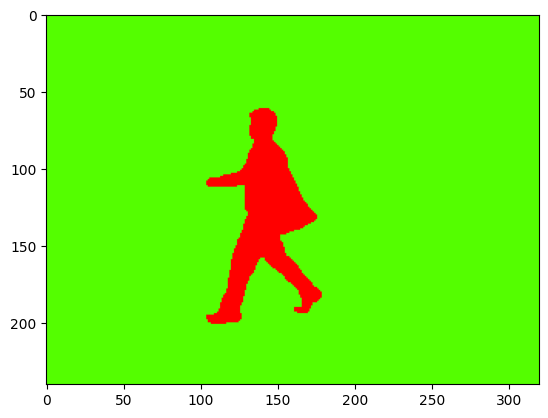

In [134]:
import matplotlib.pyplot as plt
import os
import math
import random

rand_num = random.choice(range(len(train_data)))
print(rand_num)
sample=train_data[rand_num]
sample_path=sample["path"]
sample_frames=os.listdir(sample_path)
image=plt.imread(os.path.join(sample_path,random.choice(sample_frames)))
print(f"Subject: {sample['subject']}, Condition: {sample['condition']}, Sequence: {sample['sequence']}, View: {sample['view']}, Number of frames: {sample['num_frames']}")  
plt.imshow(image, cmap='prism_r')


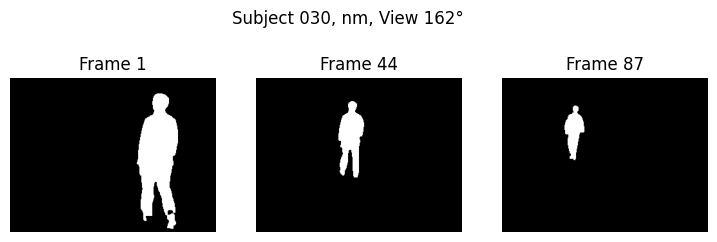

In [135]:
import matplotlib.pyplot as plt
import os

# Pick the first training sequence
rand_num = random.choice(range(len(train_data)))
sample = train_data[rand_num]
frame_files = sorted(f for f in os.listdir(sample['path']) if f.endswith('.png'))

# Select three frames evenly spaced through the sequence
indices = [0, len(frame_files)//2, len(frame_files)-1]
selected = [frame_files[i] for i in indices]

# Load and plot
plt.figure(figsize=(9, 3))
for i, fname in enumerate(selected):
    img = plt.imread(os.path.join(sample['path'], fname))
    plt.subplot(1, 3, i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(f"Frame {indices[i]+1}")
plt.suptitle(f"Subject {sample['subject']}, {sample['condition']}, View {sample['view']}°")
plt.show()


In [136]:
import tensorflow as tf

IMG_HEIGHT = 64
IMG_WIDTH  = 44

def preprocess_frame(image_path):
    """
    Reads an image file, decodes, resizes, and normalizes it.
    """
    # Read & decode
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)            # grayscale
    # Resize
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    # Normalize to [0,1]
    image = image / 255.0
    return image


In [137]:
preprocess_frame(os.path.join(sample_path, sample_frames[0]))

<tf.Tensor: shape=(64, 44, 1), dtype=float32, numpy=
array([[[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       ...,

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]],

       [[0.],
        [0.],
        [0.],
        ...,
        [0.],
        [0.],
        [0.]]], shape=(64, 44, 1), dtype=float32)>

In [138]:
import os
import numpy as np
import tensorflow as tf

IMG_HEIGHT = 64
IMG_WIDTH  = 44
SEQ_LEN    = 30

def preprocess_frame(path):
    # Read & decode
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=1)
    # Resize & normalize
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = image / 255.0
    return image.numpy()  # convert to NumPy

def build_dataset(entries):
    X_list = []
    y_list = []

    for ent in entries:
        # Get sorted frame file names
        files = sorted([f for f in os.listdir(ent['path']) if f.endswith('.png')])
        # Truncate or pad to SEQ_LEN
        files = files[:SEQ_LEN]
        while len(files) < SEQ_LEN:
            files.append(files[-1])
        # Preprocess frames
        seq = []
        for fname in files:
            img_path = os.path.join(ent['path'], fname)
            img = preprocess_frame(img_path)
            seq.append(img)
        seq_array = np.stack(seq, axis=0)  # (SEQ_LEN, H, W, 1)
        X_list.append(seq_array)
        y_list.append(int(ent['subject']) - 1)  # zero-based label

    # Stack all sequences
    X = np.stack(X_list, axis=0)  # (N, SEQ_LEN, H, W, 1)
    y = np.array(y_list, dtype=np.int32)
    return X, y

# Build datasets
X_train, y_train = build_dataset(train_data)
X_test,  y_test  = build_dataset(test_data)

print("Train data shape:", X_train.shape)
print("Train labels shape:", y_train.shape)
print("Test data shape:", X_test.shape)
print("Test labels shape:", y_test.shape)


Train data shape: (9178, 30, 64, 44, 1)
Train labels shape: (9178,)
Test data shape: (4378, 30, 64, 44, 1)
Test labels shape: (4378,)


In [143]:
import numpy as np
import matplotlib.pyplot as plt

# Shapes
print("X_train shape:", X_train.shape)  # (N, SEQ_LEN, 64, 44, 1)
print("y_train shape:", y_train.shape)
print(f"Number of training samples: {X_train.shape[0]}")
print(f"Sequence length: {X_train.shape[1]}")
print(f"Image size: {X_train.shape[2]} x {X_train.shape[3]}")
print(f"Number of unique subjects: {len(np.unique(y_train))}")

# Unique subjects in train
unique, counts = np.unique(y_train, return_counts=True)
print("Subjects:", unique)
print("Sequences per subject:", counts)




X_train shape: (9178, 30, 64, 44, 1)
y_train shape: (9178,)
Number of training samples: 9178
Sequence length: 30
Image size: 64 x 44
Number of unique subjects: 84
Subjects: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83]
Sequences per subject: [110 110 110 110  95 110 110 110 110 110 110 110 110 110 110 110 110 110
 110 110 110 110 110 110 110 109 110 110 110 110 110 110 110 110 110 110
 100 110 110 110 110 110 110 110 110 110 110 100 110 110 110 110 110 110
 110 110 110 110 110 110 110 110 110 110 110 110 110  89 110 110 110 110
 110 110 110 110 110 110 105 110 110 110 110 110]


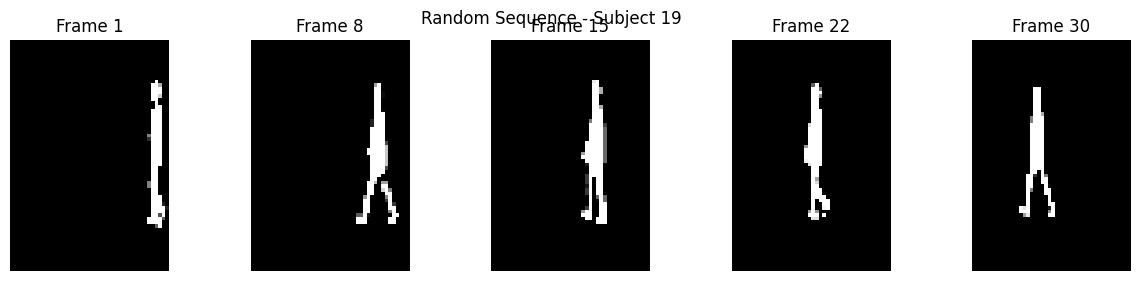

In [141]:
import random

# Pick a random sequence and show five frames
i = random.randint(0, X_train.shape[0] - 1)
seq = X_train[i]  # shape: (SEQ_LEN, 64, 44, 1)
label = y_train[i]

plt.figure(figsize=(15,3))
indices = np.linspace(0, seq.shape[0] - 1, 5, dtype=int)
for idx, frame_num in enumerate(indices):
    plt.subplot(1, 5, idx+1)
    plt.imshow(seq[frame_num,:,:,0], cmap='gray')
    plt.title(f"Frame {frame_num+1}")
    plt.axis('off')
plt.suptitle(f"Random Sequence - Subject {label}")
plt.show()


In [142]:
import numpy as np

# Save training data
np.save('X_train.npy', X_train)
np.save('y_train.npy', y_train)

# Save testing data
np.save('X_test.npy', X_test)
np.save('y_test.npy', y_test)


In [ ]:
import numpy as np

# Load training data
X_train = np.load('processed/X_train.npy')
y_train = np.load('processed/y_train.npy')

# Load testing data
X_test = np.load('processed/X_test.npy')
y_test = np.load('processed/y_test.npy')

print("Shapes after loading:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)


Shapes after loading:
X_train: (9178, 30, 64, 44, 1)
y_train: (9178,)
X_test: (4378, 30, 64, 44, 1)
y_test: (4378,)


In [2]:
# Turn on mixed precision training
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy(policy="mixed_float16") # set global policy to mixed precision 

In [3]:
mixed_precision.global_policy() # should output "mixed_float16" (if your GPU is compatible with mixed precision)

<DTypePolicy "mixed_float16">

In [4]:
import numpy as np

all_labels = np.concatenate([y_train, y_test])
num_classes = len(np.unique(all_labels))
print(f"Number of unique subjects (classes): {num_classes}")


Number of unique subjects (classes): 124


In [5]:
import tensorflow as tf

y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes)
y_test_onehot

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], shape=(4378, 124))

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

SEQ_LEN = X_train.shape[1]  # number of frames per sequence
HEIGHT = X_train.shape[2]
WIDTH = X_train.shape[3]
CHANNELS = 1
NUM_CLASSES = y_train_onehot.shape[1]

model = models.Sequential([
    # TimeDistributed applies the same CNN to each frame in the sequence
    layers.TimeDistributed(layers.Conv2D(32, (3, 3), activation='relu'), input_shape=(SEQ_LEN, HEIGHT, WIDTH, CHANNELS)),
    layers.TimeDistributed(layers.MaxPooling2D((2, 2))),
    layers.TimeDistributed(layers.Conv2D(64, (3, 3), activation='relu')),
    layers.TimeDistributed(layers.MaxPooling2D((2, 2))),
    layers.TimeDistributed(layers.Conv2D(128, (3, 3), activation='relu')),
    layers.TimeDistributed(layers.Flatten()),

    # Flatten all time steps
    layers.Flatten(),

    # Fully connected layer
    layers.Dense(128, activation='relu'),

    # Output layer with softmax for classification
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Reshaped X_train shape: (9178, 64, 44, 30)
New shape: (9178, 64, 44, 30)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 64, 44, 16)     │         4,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 22, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 22, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 5632)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │       180,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 124)            │         4,092 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 193,324 (755.17 KB)

 Trainable params: 193,324 (755.17 KB)

 Non-trainable params: 0 (0.00 B)

MemoryError: Unable to allocate 2.89 GiB for an array with shape (9178, 30, 64, 44, 1) and data type float32

In [14]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set training parameters
BATCH_SIZE = 4
EPOCHS = 10

# Callbacks for better training
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7)
]

# Train the model
print("Starting training...")
history = model.fit(
    X_train, y_train_onehot,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_test, y_test_onehot),
    callbacks=callbacks,
    verbose=1
)

print("Training completed!")


Starting training...


MemoryError: Unable to allocate 2.89 GiB for an array with shape (9178, 30, 64, 44, 1) and data type float32

In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("Available GPUs:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.20.0
Available GPUs: []


In [ ]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"{len(gpus)} GPU(s) detected and memory growth enabled.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected by TensorFlow.")



No GPU detected by TensorFlow.
